In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os

import torch
import torch.nn as nn
from torch.autograd import Variable, grad
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

import sys

import pickle
import argparse

import os

machine_path = os.getcwd()
user_root_dir = '/'.join(machine_path.split('/')[:-2])
sys.path.insert(0,'%s/redner/'%user_root_dir)
import pyredner

# In[2]:
from PIL import Image

print('PyRedner location: %s'%pyredner.__file__)

PyRedner location: /net/storage001.ib.cluster/om2/user/smadan/redner/pyredner/__init__.py


In [ ]:
if os.environ['_'].split('/')[-1] == 'python':
    print('Running in python terminal')
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset_name', type = str, required = True)
    parser.add_argument('--model_files_pickle_name', type = str, required = True)
    parser.add_argument('--category', type = str, required = False)
    args = parser.parse_args()

    DATASET_NAME = args.dataset_name
    MODEL_FILES_PICKLE_NAME = args.model_files_pickle_name
    CATEGORY = args.category

elif os.environ['_'].split('/')[-1] == 'jupyter':
    print('Running in jupyter')
    DATASET_NAME = "train_v2_shapenet_10_models"
    MODEL_FILES_PICKLE_NAME = "categories_10_models_10.pkl"
    CATEGORY = None
# In[3]:


def create_folder(folder_path):
    if not os.path.isdir(folder_path):
        print('Making new directory: %s'%folder_path)
        os.mkdir(folder_path)


# In[4]:

In [ ]:
SHAPENET_DIR = '%s/ShapeNetCore.v2'%user_root_dir

dataset_path = "%s/differentiable_graphics_ml/data/%s"%(user_root_dir, DATASET_NAME)
model_files_pickle_path = '%s/differentiable_graphics_ml/rendering/shapenet_model_subsets/%s'%(user_root_dir, MODEL_FILES_PICKLE_NAME)

create_folder(dataset_path)


# In[5]:


with open(model_files_pickle_path, 'rb') as F:
    model_files = pickle.load(F)

In [9]:
# In[6]:

def generate_uniform_on_sphere(num_points, radius):
    points = []
    for i in range(num_points):
        X = np.random.normal()
        Y = np.random.normal()
        Z = np.random.normal()

        vector = np.array([X,Y,Z])
        point = torch.tensor(radius*vector/np.linalg.norm(vector)).float()
        points.append(point)
    return points


# In[19]:


def render_shapenet_obj(obj_path, camera_position, light_position,
                        show_lights = False,render_seed = 1):
    obj_model_all = pyredner.load_obj(obj_path, return_objects=True)
    obj_model = [i for i in obj_model_all if len(i.vertices)>0]
#     m = pyredner.Material(diffuse_reflectance = torch.tensor((0.8, 0.8, 0.8), device = pyredner.get_device()), two_sided = True)
#     for part in obj_model:
#         part.material = m

    scene_cam = pyredner.automatic_camera_placement(obj_model, resolution = (224, 224))
    scene_cam.position = camera_position


    all_light_positions = [light_position]
    scene_lights = []
    for l_pos in all_light_positions:
        scene_light = pyredner.generate_quad_light(position = l_pos,
                                         look_at = torch.zeros(3),
                                         size = torch.tensor([0.5, 0.5]),
                                         intensity = torch.tensor([1.0, 1.0, 1.0]),
                                         directly_visible = show_lights)
        scene_lights.append(scene_light)

    all_objects = obj_model + scene_lights
    scene = pyredner.Scene(objects = all_objects, camera = scene_cam)
    img = pyredner.render_pathtracing(scene,num_samples=256,seed=render_seed, use_secondary_edge_sampling = False)
    im = torch.pow(img.data, 1.0/2.2).cpu()
    im = im/torch.max(im)
    image = Image.fromarray((im*255.0).numpy().astype('uint8'))
    return image, im

def get_save_names(category, instance, cam_pos, light_pos):
    cam_pos_string = "fixed_position"
    image_name = "%s_%s_%s_%s.png"%(category, instance, cam_pos_string, light_pos_string)
    tensor_name = "%s_%s_%s_%s.tens"%(category, instance, cam_pos_string, light_pos_string)
    return image_name, tensor_name

In [21]:
radius = 2.0
cam_point = np.sqrt(4/3)

cam_pos = torch.tensor([cam_point, cam_point, cam_point]).float()

In [22]:
# image, tensor =  render_shapenet_obj(model_file, cam_pos, light_pos)

In [23]:
# plt.imshow(image)
# plt.axis('off')
# plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

/net/storage001.ib.cluster/om2/user/smadan/differentiable_graphics_ml/data/train_v2_shapenet_10_models/02691156/images/02691156_67da7044f5bee4f65c6d168c6e7f59dc_fixed_position_3.908_0.840_-0.146.png
/net/storage001.ib.cluster/om2/user/smadan/differentiable_graphics_ml/data/train_v2_shapenet_10_models/02691156/tensors/02691156_67da7044f5bee4f65c6d168c6e7f59dc_fixed_position_3.908_0.840_-0.146.tens
Scene construction, time: 0.27379 s
Forward pass, time: 0.71416 s


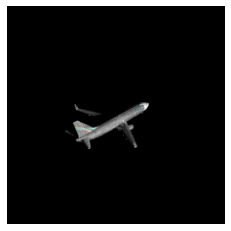

  0%|          | 0/10 [00:02<?, ?it/s]


In [26]:
# In[20]:

# In[61]:

##### Placing camera at center of first octant at fixed radius #####
##### Light moves around in a sphere of twice the radius ######

if CATEGORY:
    run_only_one_category = True
else:
    run_only_one_category = False

for category in model_files.keys():
    if run_only_one_category and category != CATEGORY:
        pass
    else:
        category_path = "%s/%s"%(dataset_path,category)
        create_folder(category_path)
        images_path = "%s/images"%category_path
        create_folder(images_path)
        tensors_path = "%s/tensors"%category_path
        create_folder(tensors_path)

        for model_file in tqdm(model_files[category]):
            instance = model_file.split('/')[7]

            # Get new light and camera positions
            sampled_points = generate_uniform_on_sphere(400,radius)
#             camera_positions = [i for i in sampled_points]
            light_positions = [2*i for i in sampled_points]
            # Render for 20 cam positions and 20 light positions
            for light_pos in light_positions:
                image_name, tensor_name = get_save_names(category, instance, cam_pos, light_pos)
                image_path = "%s/images/%s"%(category_path, image_name)
                tensor_path = "%s/tensors/%s"%(category_path, tensor_name)
                print(image_path)
                print(tensor_path)
                model_file = model_file.replace('/om5/user/smadan',user_root_dir)
                image, tensor =  render_shapenet_obj(model_file, cam_pos, light_pos)
                plt.imshow(image)
                plt.axis('off')
                plt.show()
                break
            break
        break
#                 image.save(image_path)
#                 with open(tensor_path,'wb') as F:
#                     pickle.dump(tensor, F)

In [29]:
!pwd

/net/storage001.ib.cluster/om2/user/smadan/ShapeNetCore.v2/02691156/97bd6259fd4dd69a90baeef8ba5b93e5/models


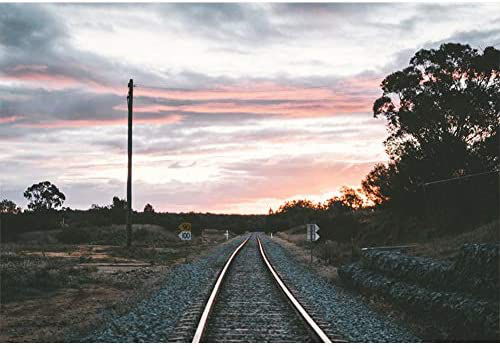

In [4]:
Image.open('background.jpg')